In [ ]:
#Import required libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib

In [ ]:
files = os.listdir('/root/.keras/datasets/flower_photos')

In [ ]:
# Download data
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)


228818944/228813984 [==============================] - 2s 0us/step


In [ ]:
#Count images
print(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

/root/.keras/datasets/flower_photos
3670


In [ ]:
#Creating dataset
batch_size = 32
img_height = 180
img_width = 180

# Defining train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Defining validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
assert(train_ds.class_names == val_ds.class_names)
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


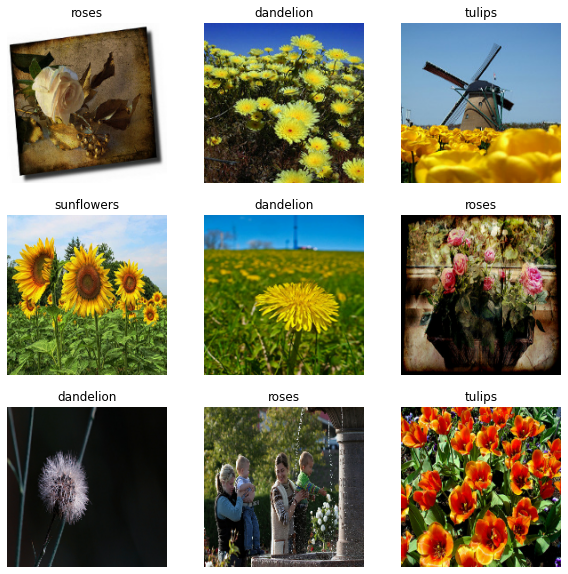

In [ ]:
# Visualize data
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])

    plt.axis("off")

In [ ]:
# Creating buffer for pre-fetching
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
#Optional here as using it as an integral part of Model.
#Standardized the data - By rescaling RGB values [0-255] to [0-1]
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.98196095


In [ ]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
#Compile model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 96s 1s/step - loss: 1.4484 - accuracy: 0.3822 - val_loss: 1.2900 - val_accuracy: 0.4809
Epoch 2/10
92/92 [==============================] - 94s 1s/step - loss: 1.0551 - accuracy: 0.5896 - val_loss: 0.9813 - val_accuracy: 0.6035
Epoch 3/10
92/92 [==============================] - 95s 1s/step - loss: 0.8685 - accuracy: 0.6672 - val_loss: 1.0301 - val_accuracy: 0.5804
Epoch 4/10
92/92 [==============================] - 94s 1s/step - loss: 0.6630 - accuracy: 0.7568 - val_loss: 1.0008 - val_accuracy: 0.6362
Epoch 5/10
92/92 [==============================] - 99s 1s/step - loss: 0.4446 - accuracy: 0.8454 - val_loss: 1.1315 - val_accuracy: 0.6417
Epoch 6/10
92/92 [==============================] - 94s 1s/step - loss: 0.2669 - accuracy: 0.9108 - val_loss: 1.3178 - val_accuracy: 0.6185
Epoch 7/10
92/92 [==============================] - 95s 1s/step - loss: 0.1522 - accuracy: 0.9479 - val_loss: 1.4813 - val_accuracy: 0.6376
Epoch 8/10
92/92 [==

Keras version: 2.4.0


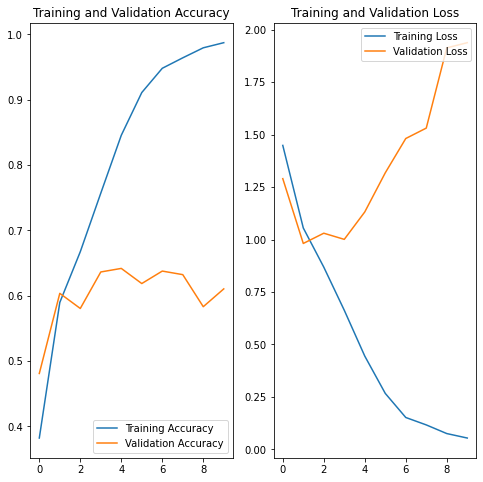

In [ ]:
print('Keras version:',keras.__version__)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

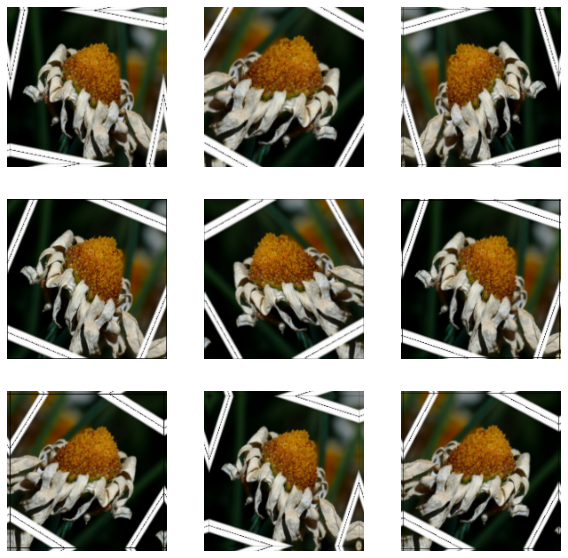

In [ ]:
# Optimization : Data Augmentation
data_augmentation  = keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
                                          layers.experimental.preprocessing.RandomRotation(0.1),
                                          layers.experimental.preprocessing.RandomZoom(0.1)])

# Visualize
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
# Regularization : Dropout
model = Sequential([
                    data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#Compile the model
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [ ]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 113s 1s/step - loss: 1.2720 - accuracy: 0.4700 - val_loss: 1.1055 - val_accuracy: 0.5518
Epoch 2/10
92/92 [==============================] - 112s 1s/step - loss: 1.0471 - accuracy: 0.5804 - val_loss: 0.9862 - val_accuracy: 0.6022
Epoch 3/10
92/92 [==============================] - 112s 1s/step - loss: 0.9321 - accuracy: 0.6287 - val_loss: 1.0551 - val_accuracy: 0.6090
Epoch 4/10
92/92 [==============================] - 112s 1s/step - loss: 0.8915 - accuracy: 0.6577 - val_loss: 0.8466 - val_accuracy: 0.6757
Epoch 5/10
92/92 [==============================] - 111s 1s/step - loss: 0.8346 - accuracy: 0.6710 - val_loss: 0.8262 - val_accuracy: 0.6580
Epoch 6/10
92/92 [==============================] - 112s 1s/step - loss: 0.7911 - accuracy: 0.6921 - val_loss: 0.7594 - val_accuracy: 0.7098
Epoch 7/10
92/92 [==============================] - 112s 1s/step - loss: 0.7542 - accuracy: 0.7101 - val_loss: 0.7931 - val_accuracy: 0.6826
Epoch 8/10
92

Keras version: 2.4.0


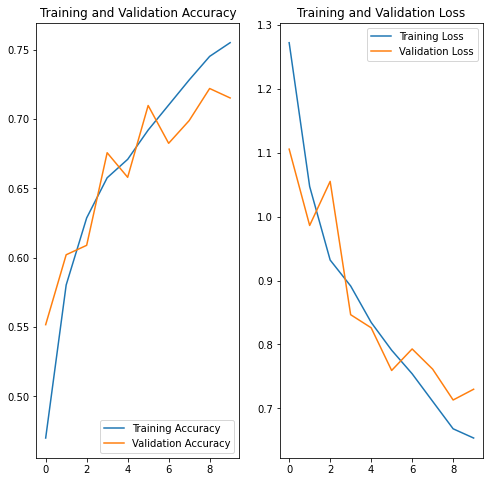

In [ ]:
print('Keras version:',keras.__version__)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Predict
sunflower_path = '/rose.jfif'

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


This image most likely belongs to roses with a 98.80 percent confidence.


In [ ]:
model.save('/flower_classifier')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /flower_classifier/assets
